<a href="https://colab.research.google.com/github/mojtabaSefidi/Machine-Learning-with-Graphs/blob/main/MLG_Ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Essential Packages

In [ ]:
!pip install -q torch_geometric
!pip install -q torch-sparse==0.6.13
!pip install -q torch_scatter

     |████████████████████████████████| 48 kB 3.7 MB/s 


## Install Essential Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import networkx as nx
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures

## Read the Dataset

In [ ]:
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG', transform=NormalizeFeatures())

In [ ]:
train_split_percentage = 0.8
cut_index = int(len(dataset)*train_split_percentage)

dataset = dataset.shuffle()
train_dataset = dataset[:cut_index]
test_dataset = dataset[cut_index:]

In [ ]:
from torch_geometric.loader import DataLoader

def batch_generator(train_dataset, test_dataset, batch_size, shuffle=True):
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
  test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
  return train_data_loader, test_data_loader

train_data_loader, test_data_loader =  batch_generator(train_dataset, test_dataset, batch_size=32)

for step, data in enumerate(train_data_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()


Step 1:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1292], x=[580, 7], edge_attr=[1292, 4], y=[32], batch=[580], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1372], x=[612, 7], edge_attr=[1372, 4], y=[32], batch=[612], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1140], x=[526, 7], edge_attr=[1140, 4], y=[32], batch=[526], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(edge_index=[2, 1270], x=[572, 7], edge_attr=[1270, 4], y=[32], batch=[572], ptr=[33])

Step 5:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 886], x=[402, 7], edge_attr=[886, 4], y=[22], batch=[402], ptr=[23])



In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool

In [ ]:
class GCN_Mean(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_Mean, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


In [ ]:
class GCN_Max(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_Max, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_max_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [ ]:
# class GCN_Min(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super(GCN_Min, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.conv3 = GCNConv(hidden_channels, hidden_channels)
#         self.lin = Linear(hidden_channels, dataset.num_classes)

#     def forward(self, x, edge_index, batch):
#         # 1. Obtain node embeddings 
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         x = self.conv3(x, edge_index)

#         # 2. Readout layer
#         x = global_min_pool(x, batch)  # [batch_size, hidden_channels]

#         # 3. Apply a final classifier
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin(x)
        
#         return x

In [ ]:
model = GCN_Mean(hidden_channels=32)
print(model)

GCN_Mean(
  (conv1): GCNConv(7, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_data_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_data_loader)
    test_acc = test(test_data_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6867, Test Acc: 0.5789
Epoch: 002, Train Acc: 0.6867, Test Acc: 0.5789
Epoch: 003, Train Acc: 0.6867, Test Acc: 0.5789
Epoch: 004, Train Acc: 0.6867, Test Acc: 0.5789
Epoch: 005, Train Acc: 0.6867, Test Acc: 0.5789
Epoch: 006, Train Acc: 0.7133, Test Acc: 0.6316
Epoch: 007, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 008, Train Acc: 0.7333, Test Acc: 0.6842
Epoch: 009, Train Acc: 0.7400, Test Acc: 0.6316
Epoch: 010, Train Acc: 0.7467, Test Acc: 0.6842
Epoch: 011, Train Acc: 0.7533, Test Acc: 0.6579
Epoch: 012, Train Acc: 0.7667, Test Acc: 0.7368
Epoch: 013, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 014, Train Acc: 0.7667, Test Acc: 0.7368
Epoch: 015, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 016, Train Acc: 0.7667, Test Acc: 0.7105
Epoch: 017, Train Acc: 0.7667, Test Acc: 0.7368
Epoch: 018, Train Acc: 0.7667, Test Acc: 0.7368
Epoch: 019, Train Acc: 0.7667, Test Acc: 0.6579
Epoch: 020, Train Acc: 0.7600, Test Acc: 0.7105
Epoch: 021, Train Acc: 0.7733, Test Acc:

## Part 1 : Dataset Details

In [ ]:
def Information_Extaction(dataset):
  print('There is %d graph in the dataset.' %len(dataset))
  print('The graph has %d nodes.' %dataset[0].num_nodes)
  print('The graph has %d edges.' %dataset[0].num_edges)
  print('Each node has %d features.' %dataset[0].num_features)
  print('These are %d classes.'  %dataset.num_classes)
  print("The Average degree for each node is %d." %round((2*dataset[0].num_edges) / (dataset[0].num_nodes),4))
  print('There are %d training nodes in the dataset.' %dataset[0].train_mask.sum().item())
  return

In [ ]:
Information_Extaction(dataset)

There is 188 graph in the dataset.
The graph has 17 nodes.
The graph has 38 edges.
Each node has 7 features.
These are 2 classes.
The Average degree for each node is 4.


AttributeError: ignored

## Part 4 : Graph visualization

In [ ]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


def plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, n_epochs, title):
    
    plt.figure(figsize=(12,6),linewidth = 7, edgecolor="whitesmoke")    
    n = n_epochs
    
    plt.plot(list(range(1, n_epochs+1)), list_train_acc, color='orange',marker=".")
    plt.plot(list(range(1, n_epochs+1)), list_train_loss,'b',marker=".")
    
    plt.plot(list(range(1, n_epochs+1)), list_val_acc,'r')  
    plt.plot(list(range(1, n_epochs+1)), list_val_loss,'g')
    
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    
    # plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle(title, size=16, y=0.927)
    plt.show()


In [ ]:
# visualize(dataset[0].x, color=dataset[0].y)

## Additional Libraries for GNN

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv

## Part 5 : GCN Implementation

In [ ]:
# class GCN(torch.nn.Module):
#     def __init__(
#         self,
#         dataset,
#         hidden_channel=256,
#         learning_rate=0.01,
#         min_valid_loss = np.inf,
        
        
#         ):
      
#         super().__init__()
#         self.conv1 = GCNConv(dataset.num_node_features, hidden_channel)
#         self.conv2 = GCNConv(hidden_channel, hidden_channel)
#         self.classifier = Linear(hidden_channel, dataset.num_classes)
        
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#         self.data = dataset[0].to(device)
#         self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#         self.criterion = torch.nn.CrossEntropyLoss()
#         self.min_valid_loss = min_valid_loss

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = self.conv1(x, edge_index)
#         x = torch.tanh(x)
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = torch.tanh(x)
#         return self.classifier(x)

#     def training(self):
#           save_model_flag = False
#           model.train()
#           self.optimizer.zero_grad()
#           out = model(self.data)
#           train_loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
#           validation_loss = self.criterion(out[self.data.val_mask], self.data.y[self.data.val_mask])
#           if self.min_valid_loss > validation_loss:
#               save_model_flag = True
#           train_loss.backward()
#           self.optimizer.step()

#           return train_loss, validation_loss, save_model_flag 

#     def test(self):
#           out = model(self.data)
#           test_loss = self.criterion(out[self.data.test_mask], self.data.y[self.data.test_mask])
#           pred = out.argmax(dim=1)
#           test_correct = pred[self.data.test_mask] == self.data.y[self.data.test_mask]
#           test_acc = int(test_correct.sum()) / int(self.data.test_mask.sum())
#           return test_acc, test_loss
    
#     def fit_optimize(self, epochs):
#       for epoch in range(1, epochs+1):
#         train_loss, validation_loss, save_model_flag = self.training()
#         print(f'Epoch: {epoch:03d}, Trian Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')
#         if save_model_flag:
#           self.min_valid_loss = validation_loss
#           print(f"Best validation loss: {self.min_valid_loss:.4f}")
#           print(f"Saving best model for epoch: {epoch}")
#           torch.save(model,'best_model.pth')


In [ ]:
class GCN_2(torch.nn.Module):
    def __init__(
        self,
        hidden_channel=256,
        learning_rate=0.01
        
        ):
      
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channel)
        self.conv2 = GCNConv(hidden_channel, dataset.num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
class GCN_3(torch.nn.Module):
    def __init__(
        self,
        hidden_channel=256,
        learning_rate=0.01
        
        ):
      
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channel)
        self.conv2 = GCNConv(hidden_channel, hidden_channel)
        self.conv3 = GCNConv(hidden_channel, dataset.num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x


In [ ]:
class GCN_5(torch.nn.Module):
    def __init__(
        self,
        hidden_channel=256,
        learning_rate=0.01
        
        ):
      
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channel)
        self.conv2 = GCNConv(hidden_channel, hidden_channel)
        self.conv3 = GCNConv(hidden_channel, hidden_channel)
        self.conv4 = GCNConv(hidden_channel, hidden_channel)
        self.conv5 = GCNConv(hidden_channel, dataset.num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, p=0.5, training=self.training)        
        
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv3(x, edge_index)
        return x


In [ ]:
model = GCN_2(hidden_channel = 16)
print(model)

GCN_2(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
import numpy as np
learning_rate = 0.01
min_valid_loss = np.inf
n_epochs=150

In [ ]:
def define_loss_optimizer(learning_rate=0.01):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = torch.nn.CrossEntropyLoss()
  return optimizer, criterion

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
optimizer, criterion = define_loss_optimizer(learning_rate)

In [ ]:
def train_one_epoch(model, data, min_valid_loss):
      save_model_flag = False
      model.train()
      optimizer.zero_grad()
      
      out = model(data)
      train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
      validation_loss = criterion(out[data.val_mask], data.y[data.val_mask])
      
      pred = out.argmax(dim=1)
      train_correct = pred[data.train_mask] == data.y[data.train_mask]
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
      validation_correct = pred[data.val_mask] == data.y[data.val_mask]
      validation_acc = int(validation_correct.sum()) / int(data.val_mask.sum())
      
      if min_valid_loss > validation_loss:
          save_model_flag = True
      
      train_loss.backward()
      optimizer.step()

      return train_loss, train_acc,  validation_loss, validation_acc, save_model_flag 

def train(model,data, n_epochs, best_model_saving_path, min_valid_loss=np.inf):
  list_train_loss, list_train_acc, list_val_loss, list_val_acc = [], [], [], []
  
  for epoch in range(1, n_epochs+1):
    train_loss, train_acc, validation_loss, validation_acc, save_model_flag = train_one_epoch(model, data, min_valid_loss)
    list_train_loss.append(float(train_loss.detach()))
    list_train_acc.append(train_acc)
    list_val_loss.append(float(validation_loss.detach()))
    list_val_acc.append(validation_acc)
    print(f'Epoch: {epoch:03d}, Trian Loss: {train_loss:.4f}, Trian Accuracy: {train_acc:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.4f}')
    
    if save_model_flag:
      min_valid_loss = validation_loss
      print(f" ******* Best model updated in epoch: {epoch}, Best validation loss: {min_valid_loss:.4f} *******")
      torch.save(model, best_model_saving_path)
  
  return list_train_loss, list_train_acc, list_val_loss, list_val_acc

def test(model, data):
      model.eval()
      out = model(data)
      test_loss = criterion(out[data.test_mask], data.y[data.test_mask])
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc, test_loss

## Test Performance

In [ ]:
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train(model, data, n_epochs, 'best_model_saving_path.pth', min_valid_loss)

Epoch: 001, Trian Loss: 1.9465, Trian Accuracy: 0.0714, Validation Loss: 1.9464, Validation Accuracy: 0.1160
 ******* Best model updated in epoch: 1, Best validation loss: 1.9464 *******
Epoch: 002, Trian Loss: 1.9407, Trian Accuracy: 0.1857, Validation Loss: 1.9415, Validation Accuracy: 0.2280
 ******* Best model updated in epoch: 2, Best validation loss: 1.9415 *******
Epoch: 003, Trian Loss: 1.9348, Trian Accuracy: 0.3786, Validation Loss: 1.9396, Validation Accuracy: 0.2880
 ******* Best model updated in epoch: 3, Best validation loss: 1.9396 *******
Epoch: 004, Trian Loss: 1.9271, Trian Accuracy: 0.4786, Validation Loss: 1.9370, Validation Accuracy: 0.2940
 ******* Best model updated in epoch: 4, Best validation loss: 1.9370 *******
Epoch: 005, Trian Loss: 1.9196, Trian Accuracy: 0.5357, Validation Loss: 1.9324, Validation Accuracy: 0.3400
 ******* Best model updated in epoch: 5, Best validation loss: 1.9324 *******
Epoch: 006, Trian Loss: 1.9080, Trian Accuracy: 0.5929, Validatio

In [ ]:
model = torch.load('best_model_saving_path.pth')
test_acc, test_loss = test(model, data)
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.7960, Test loss: 0.6970


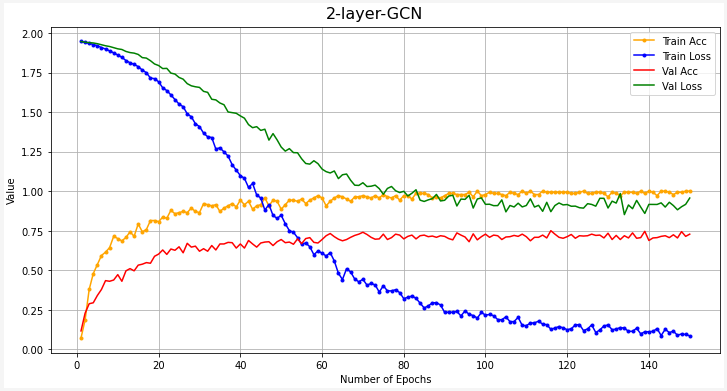

In [ ]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, n_epochs, title='2-layer-GCN')


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


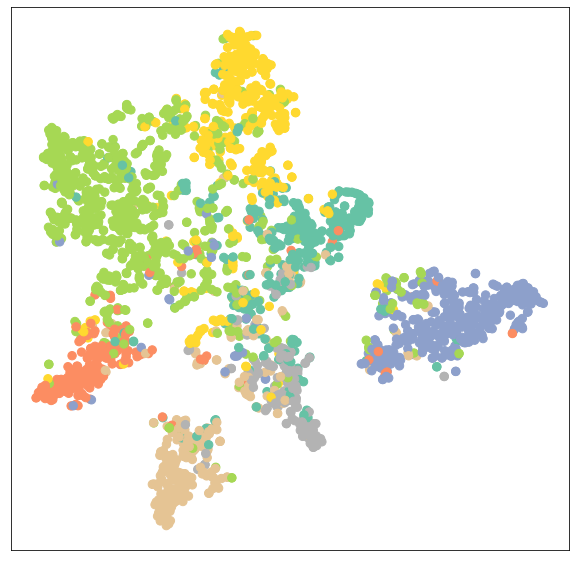

In [ ]:
model.eval()
out = model(data)
visualize(out, color=data.y)